**Car-ing is sharing**, an auto dealership company for car sales and rental, is taking their services to the next level thanks to **Large Language Models (LLMs)**.

As their newly recruited AI and NLP developer, you've been asked to prototype a chatbot app with multiple functionalities that not only assist customers but also provide support to human agents in the company.

The solution should receive textual prompts and use a variety of pre-trained Hugging Face LLMs to respond to a series of tasks, e.g. classifying the sentiment in a car’s text review, answering a customer question, summarizing or translating text, etc.


Project from DataCamp

Author: Akash Kharita (akharita1999@gmail.com)

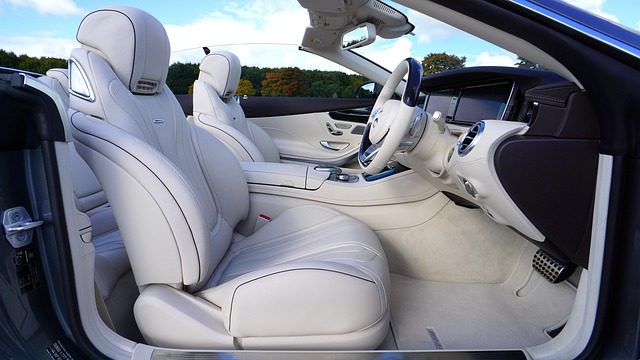

In [2]:
# Import necessary packages
import pandas as pd
import torch

from transformers import logging
logging.set_verbosity(logging.WARNING)

# load HF library
from transformers import pipeline

2025-05-07 13:05:51.941872: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746623151.955976    4710 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746623151.960401    4710 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746623151.972357    4710 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746623151.972370    4710 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746623151.972372    4710 computation_placer.cc:177] computation placer alr

# Task 1. Sentiment-Classification

Understand the sentiment of a review whether it is positive or negative

## 1.1 Load Car Review Data
We begin by loading the dataset from car_reviews.csv, which contains customer reviews along with their associated sentiment (class) labels. Each entry in the file is separated by a semicolon (;), so we use that as the delimiter when reading the data.

In [3]:
# reading the dataframe
df = pd.read_csv("data/car_reviews.csv", delimiter = ';')

# printing first few columns to check the structure. 
print(df.columns)
print(df.head())

Index(['Review', 'Class'], dtype='object')
                                              Review     Class
0  I am very satisfied with my 2014 Nissan NV SL....  POSITIVE
1  The car is fine. It's a bit loud and not very ...  NEGATIVE
2  My first foreign car. Love it, I would buy ano...  POSITIVE
3  I've come across numerous reviews praising the...  NEGATIVE
4  I've been dreaming of owning an SUV for quite ...  POSITIVE


## 1.2 Run a pre-trained sentiment classifier on the reviews


### Loading the pre-trained model

In this section, we will use a pre-trained transformer model to perform sentiment analysis on the car reviews. We will utilize the `transformers` library to load a sentiment analysis pipeline and apply it to our dataset.

### What is `pipeline`?

A `pipeline` is a module that helps with
 - loading,
 - preprocessing,
 - tokenizing,
 - predicting
 - converting the output into human friendly.

for any deep learning model. its an umbrella resource for all. 


So for any task and model the format is  
`pipeline(task = 'sentiment-analysis', model = 'distilbert-base-uncased-finetuned-sst-2-english')`

### What is model here?
Let's understand more about the model used here 

distilbert -  A lighter version of BERT, an encoding only model typically for tasks like sentiment-analysis. 
base - Model size - base = medium (not small, not large)
uncased - Does not differentiate upper/lower cases (Love = LOVE)
finetuned-sst-2 - This model was trained on SST-2 dataset, Stanford Sentiment Treebank v2
english - language of training model. 

In [4]:
classifier = pipeline(task = 'sentiment-analysis', model = 'distilbert-base-uncased-finetuned-sst-2-english')

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


## 1.3 Classifying the input. 

One may ask where is the tokenization step? 

when we specify classifier(input), then pipeline internally tokenizes and the token depends on the model being used. 
Usually the process is tokenize+pad+truncate+model forward pass + decode. 

There situations where we may need to tokenize first, but not in this case, here we can directly use the forward pass of the model on the input. 

Note that the classifier takes the list of strings (or sentences) as input.

### 1.3.1 Explanation of the output of the function
The output of the `classifier(input)` contains two things  - labels (self explanatory) and score. This score reflects model's confidence in its predictions, its actually the output of the softmax prob function. 

In [5]:
# Extract data
input = df['Review'].values.tolist()

# Predict sentiments
predicted_labels  = classifier(input)
print(predicted_labels)

[{'label': 'POSITIVE', 'score': 0.929397702217102}, {'label': 'POSITIVE', 'score': 0.8654273152351379}, {'label': 'POSITIVE', 'score': 0.9994640946388245}, {'label': 'NEGATIVE', 'score': 0.9935314059257507}, {'label': 'POSITIVE', 'score': 0.9986565113067627}]


## 1.4 Evaluate the model performance

### 1.4.1 Convert predictions to binary labels {0,1}

Ok so the outputs are labels and scores. If we want to compute performance metrics such as accuracy or F1, we need to first convert the categorical labels into numerical. We will also need to convert the true labels into numerical format. 

In [6]:
# Map labels to 0 (NEGATIVE) or 1 (POSITIVE)
predictions = [1 if label['label'] == 'POSITIVE' else 0 for label in predicted_labels]
print(predictions)


[1, 1, 1, 0, 1]


### 1.4.2 Prepare true labels for evaluation

Note that we need to convert it into list because predictions and references should be list of sentences or list of strings. 

In [7]:
# True binary labels from the CSV (assuming 'POSITIVE' and 'NEGATIVE')
true_labels = df['Class'].head(5).map({'POSITIVE': 1, 'NEGATIVE': 0}).tolist()


### 1.4.3 Calculate Accuracy & F1 score. 

We will be using the HF's evaluate library. Evaluate library contains all the necessary metrics. 

In [8]:
import evaluate

# Load metrics
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

# Compute
accuracy_result = accuracy.compute(predictions=predictions, references=true_labels)
f1_result = f1.compute(predictions=predictions, references=true_labels)

# Print results
print("Accuracy:", accuracy_result['accuracy'])
print("F1 Score:", f1_result['f1'])


Accuracy: 0.8
F1 Score: 0.8571428571428571


# Task 2: Language Translation: English to Spanish

Due to computational restrictions, we are just going to take the first two sentences of the first review and translate it into spanish using our LLM. 

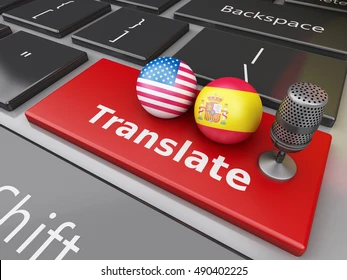

## 2.1 Load the data

Before that we have to import some necessary libaries. 
NLTK = Natural Language Toolkit

Its a trusted library that is used a lot in NLP, research and even in production

punkt is a model that identifies the boundaries between sentences. 

## 2.2 Preparing the input 
We will extract the first two sentence from the first review and then join them. 

In [9]:
# Get the first review
first_review = df['Review'][0]

# Split into sentences
sentences = first_review.split('.')[0:2]

# join the sentences to create input
input_text = ". ".join(sentences) + "."

# Take the first 2 sentences for translation
print("Original (English):", input_text)

Original (English): I am very satisfied with my 2014 Nissan NV SL.  I use this van for my business deliveries and personal use.


## 2.3 Translating the input text

Just a bit of context about the model that is used here - 
Helsinki-NLP : Research group at University of Helsinki (Finland)
opus-mt : Large multilingual project. 
en-to-es: english to espaniol



In [10]:
translator = pipeline("translation", model="Helsinki-NLP/opus-mt-en-es")
translated_output = translator(input_text)
translated_review = translated_output[0]['translation_text']
print("Translated (Spanish):", translated_review)

config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/312M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/312M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/826k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.59M [00:00<?, ?B/s]

Device set to use cpu


Translated (Spanish): Estoy muy satisfecho con mi Nissan NV SL 2014. Uso esta camioneta para mis entregas de negocios y uso personal.


### 2.3.1 Reading the ground truth

In [11]:
# Load from .txt file
with open("data/reference_translations.txt", "r", encoding="utf-8") as f:
    reference_translation = f.readline().strip()

print(reference_translation)

Estoy muy satisfecho con mi Nissan NV SL 2014. Utilizo esta camioneta para mis entregas comerciales y uso personal.


## 2.4 Evaluating the results



Note the following is very important in case of LLMs. 
BLEU is commonly used to evaluate LLM translation. For single sentence comparison BLEU expects 
- predictions - list of strings (one string per sentence)
- references  - list of list of strings (each inner list = all possible correct translations)

In [12]:
# Convert to BLEU format (list of list of tokens)
references = [[reference_translation]]
predictions = [translated_review]


bleu = evaluate.load("bleu")
bleu_score = bleu.compute(predictions= predictions, references= references)
print("BLEU Score:", bleu_score['bleu'])

BLEU Score: 0.6888074582865503


# Task 3: Extracting QA 

Answering a question "What de he like about the brand?" based on the second review. 

Ok so we are using a minilm-uncased-squad2 LLM here. 

- deepset : The organization that trained and released the model (known for Haystack QA framework)
- minilm : The base model - a super lightweight, fast version of BERT (great for low latency)
- uncased : The model ignores capitalization (treats BMW and bmw as same)
- squad2 : Trained on SQUAD 2.0 dataset. 

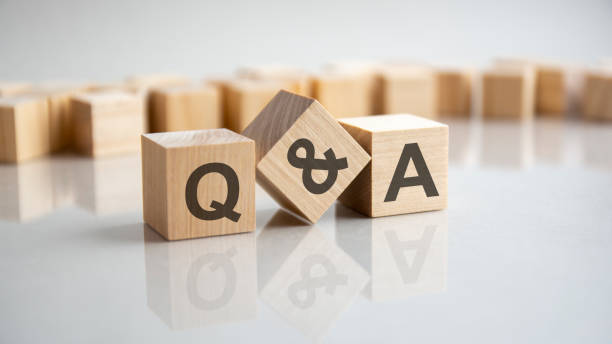

In [14]:
# Load the extractive QA model
qa_pipeline = pipeline(task = "question-answering", model = "deepset/minilm-uncased-squad2")

# Load your dataset
second_review = df['Review'].iloc[1]

# Define question and context
question = "What did he like about the brand?"
context = second_review

Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


## 3.1 Run the QA model

The output contains following - 

- score : A confidence score between 0 and 1, that indicates the model confidence that this is a best answer.
- start & end: The position in the context where the answer is extracted.
- answer: The output answer. 

In [15]:
# Run the QA model
output = qa_pipeline(question=question, context=context)

# Extract the answer
answer = output['answer']

# Print result
print(f"Question: {question}")
print(f"Context: {context}")
print(f"Answer: {answer}")

Question: What did he like about the brand?
Context: The car is fine. It's a bit loud and not very powerful. On one hand, compared to its peers, the interior is well-built. The transmission failed a few years ago, and the dealer replaced it under warranty with no issues. Now, about 60k miles later, the transmission is failing again. It sounds like a truck, and the issues are well-documented. The dealer tells me it is normal, refusing to do anything to resolve the issue. After owning the car for 4 years, there are many other vehicles I would purchase over this one. Initially, I really liked what the brand is about: ride quality, reliability, etc. But I will not purchase another one. Despite these concerns, I must say, the level of comfort in the car has always been satisfactory, but not worth the rest of issues found.
Answer: ride quality, reliability


# Task 4: Summarization 

Summarizing the last review of the dataset into approximately 50-55 tokens. 



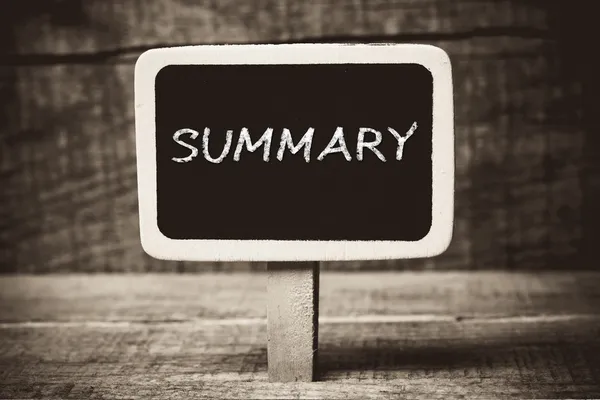

## 4.1 Loading the dataset. 

In [19]:
last_review = df['Review'].iloc[-1]
print(last_review)

I've been dreaming of owning an SUV for quite a while, but I've been driving cars that were already paid for during an extended period. I ultimately made the decision to transition to a brand-new car, which, of course, involved taking on new payments. However, given that I don't drive extensively, I was inclined to avoid a substantial financial commitment. The Nissan Rogue provides me with the desired SUV experience without burdening me with an exorbitant payment; the financial arrangement is quite reasonable. Handling and styling are great; I have hauled 12 bags of mulch in the back with the seats down and could have held more. I am VERY satisfied overall. I find myself needing to exercise extra caution when making lane changes, particularly owing to the blind spots resulting from the small side windows situated towards the rear of the vehicle. To address this concern, I am actively engaged in making adjustments to my mirrors and consciously reducing the frequency of lane changes. The

## 4.2 Load the summarization pipeline. 

Note that do_sample brings the creativity, if its false, then the model just outputs similar to inputs without any randomization, it will summarize what the input said without any modifications. 

Another Note, the output of a summarizer is always a list and hence summary[0]

In [ ]:
# Load summarization

summarizer = pipeline("summarization", model = "facebook/bart-large-cnn")

# Run summarization (aiming for ~ 5- -55 tokens)
summary = summarizer(last_review, max_length = 55, min_length = 45, do_sample = False)


# Extract text
summarized_text = summary[0]['summary_text']

# Print result
print(summarized_text)
